# Context

Todos:
* Create xtask for publishing this: http://www.kasimte.com/adding-and-including-jupyter-notebooks-as-jekyll-blog-posts
    * jupyter nbconvert --no-input --to html Open\ hand\ pass\ on\ bower\ analysis.ipynb --output-dir ../../../docs/_drafts/
    * ^ this will hide all of the code
    * Need an xtask to append the jekyll stuff to top of file
* Look at docs on hiding cell input by default
May need to analyze in rust for speed

This post analyzes the results of...

In [3]:
# imports, definitions, and data loading
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

with open("../infostates.open-hand-20m.json") as f:
    raw_data = json.load(f)
print("loaded {} infostates".format(len(raw_data)))
print(raw_data[0])

cards = [
    "Js",
    "Jc",
    "As",
    "Ks",
    "Qs",
    "Ts",
    "9s",
    "Ac",
    "Kc",
    "Qc",
    "Tc",
    "9c",
    "Ah",
    "Kh",
    "Qh",
    "Th",
    "9h",
    "Ad",
    "Kd",
    "Qd",
    "Td",
    "9d",
    "Jh",
    "Jd",
]

loaded 269187 infostates
{'infostate': 'QcTs9hJhQhJsPPPPPPP', 'hand': ['Qc', 'Ts', '9h', 'Jh', 'Qh'], 'policy': {'D': 0.05882357785466272, 'H': 0.8823528442906744, 'C': 0.05882357785466272}}


In [4]:
# Calculate pickup probs
def pickup_probs(data):
    df = pd.DataFrame.from_records(data)

    pickup_mask = df.policy.apply(lambda x: "T" in x)
    df = df[pickup_mask]
    df = df[df.infostate.str.endswith("JsPPP")]

    pickup_probs = []

    order = []
    for c in cards:
        total_take = 0
        count = 0
        card_mask = df.hand.apply(lambda x: c in x)
        avg = df[card_mask].policy.apply(lambda x: x["T"]).mean()
        order += [(c, avg)]
    order.sort(key=lambda x: x[1], reverse=True)

    order = [x[0] for x in order]

    for c1 in cards:
        for c2 in cards:
            if c1 == c2:
                pickup_probs += [(c1, c2, 0.5)]
            else:
                card_mask = df.hand.apply(lambda x: c1 in x and c2 in x)
                avg = df[card_mask].policy.apply(lambda x: x["T"]).mean()
                pickup_probs += [(c1, c2, avg)]

    return (pickup_probs, order)


probs, order = pickup_probs(raw_data)

## Analyzing high-level strategy

We can plot a heatmap of the bots policy based on what cards are in a hand. Each cell represents all hands containing both of those cards. The color of the cell represents the probability of the bot picking up the jack of spades. The blue colors mean to pickup the jack more than 50% of the time. While red colors are for <50% of the time. The cards are sorted from highest likelihood of pickup to lowest.

As an example, the top left area of the heatmap represents when the agent has multiple spades cards (would be trump). This area is dark blue -- as expected, the bot is likely to pickup the jack of spades if it already has many spades in it's hand.

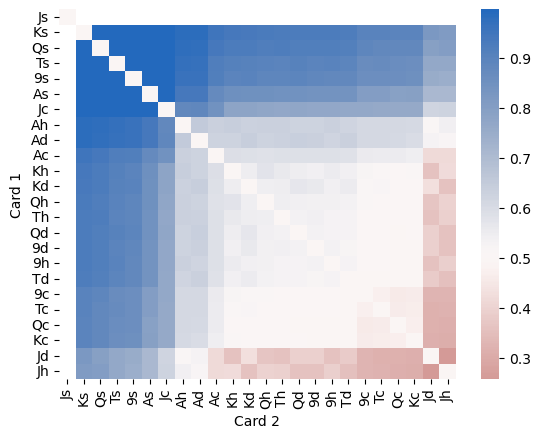

In [32]:
# Generate pickup vs pass heatmap
df = pd.DataFrame.from_records(probs, columns=["Card 1", "Card 2", "pickup_prob"])
df = df.pivot(index="Card 1", columns="Card 2")
df = df.reindex(order)
df = df["pickup_prob"].reindex(order, axis=1)


sns.heatmap(
    df,
    cmap=sns.color_palette("vlag_r", as_cmap=True),
    center=0.5,
    annot=False,
    fmt="0.2f",
)
plt.show()

Five major areas for the heatmap emerge:

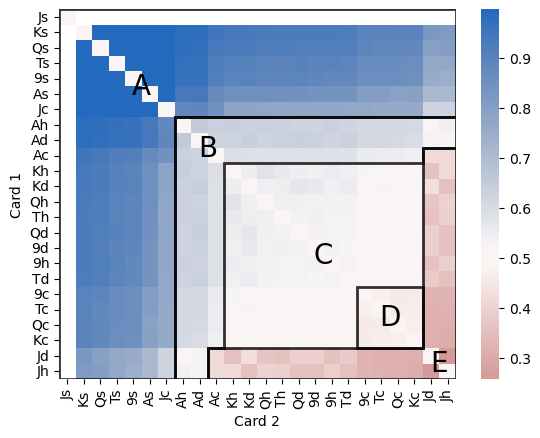

In [30]:
# Generate annotated heat map


ax = sns.heatmap(
    df,
    cmap=sns.color_palette("vlag_r", as_cmap=True),
    center=0.5,
    annot=False,
    fmt="0.2f",
)

import matplotlib.path as mpath
import matplotlib.patches as mpatches

Path = mpath.Path
spades = [
    (Path.MOVETO, (0, 0)),
    (Path.LINETO, (24, 0)),
    (Path.LINETO, (24, 7)),
    (Path.LINETO, (7, 7)),
    (Path.LINETO, (7, 24)),
    (Path.LINETO, (0, 24)),
    (Path.CLOSEPOLY, (0, 0)),
]

red_jacks = [
    (Path.MOVETO, (9, 24)),
    (Path.LINETO, (24, 24)),
    (Path.LINETO, (24, 9)),
    (Path.LINETO, (22, 9)),
    (Path.LINETO, (22, 22)),
    (Path.LINETO, (9, 22)),
    (Path.CLOSEPOLY, (9, 24)),
]

offsuit_aces = [
    (Path.MOVETO, (7, 24)),
    (Path.LINETO, (7, 7)),
    (Path.LINETO, (24, 7)),
    (Path.LINETO, (24, 9)),
    (Path.LINETO, (22, 9)),
    (Path.LINETO, (22, 10)),
    (Path.LINETO, (10, 10)),
    (Path.LINETO, (10, 22)),
    (Path.LINETO, (9, 22)),
    (Path.LINETO, (9, 24)),
    (Path.CLOSEPOLY, (7, 24)),
]

clubs = [
    (Path.MOVETO, (18, 18)),
    (Path.LINETO, (22, 18)),
    (Path.LINETO, (22, 22)),
    (Path.LINETO, (18, 22)),
    (Path.CLOSEPOLY, (18, 18)),
]


def add_patch(path, ax, color):
    codes, verts = zip(*path)
    path = mpath.Path(verts, codes)
    patch = mpatches.PathPatch(path, alpha=0.8, lw=2, edgecolor=color, fill=False)
    ax.add_patch(patch)


add_patch(spades, ax, "black")
add_patch(red_jacks, ax, "black")
add_patch(offsuit_aces, ax, "black")
add_patch(clubs, ax, "black")

ax.text(5, 5, "A", fontsize=20, color="black", ha="center", va="center")
ax.text(9, 9, "B", fontsize=20, color="black", ha="center", va="center")
ax.text(16, 16, "C", fontsize=20, color="black", ha="center", va="center")
ax.text(20, 20, "D", fontsize=20, color="black", ha="center", va="center")
ax.text(23, 23, "E", fontsize=20, color="black", ha="center", va="center")
plt.show()

| Area | Recommended action|
|---------------------------------------|-------------------|
|A) At least one spade in hand          | Always pickup, would have many trump cards |
|B) At least one off-suit ace in hand   | Usually pickup, high non-trump cards |
|C) Other cards                         ||
|D) Low clubs                           ||
|E) Red jack                            | Rarely pickup, would have highest or second highest card if someone else calls a red suit as trump |

## Better understanding what's going on

The heatmap gives hints to what the features should be for the decision tree


## With decision tree can review outliers

Is this based on the expected value of what other players have?

Create function to go from

Questions:
* Why is `JcQcJhAh9d` a never take? Are there other JC never takes? -- decision tree to find policy when Jc
* General decision tree policy

## What happens -- why is this recommended

Run a number of games where have certain hand -- categorize results for passing and taking the card -- use some of these as example play
    * For example, does having Jh or Jd make it more likely to euchre, so that's why taking it?

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2118283624490465


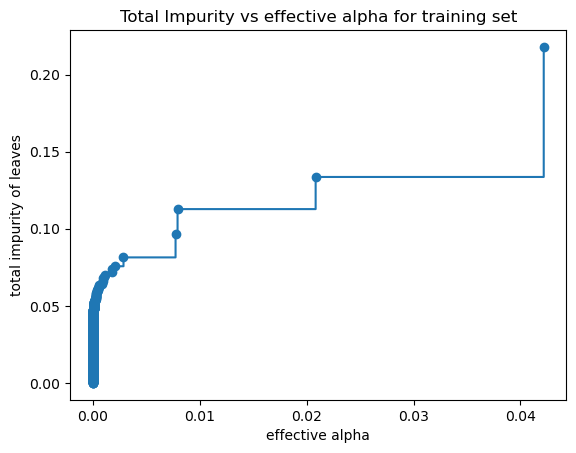

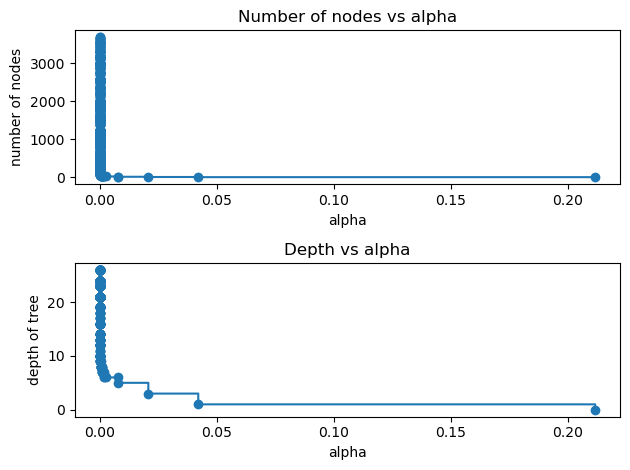

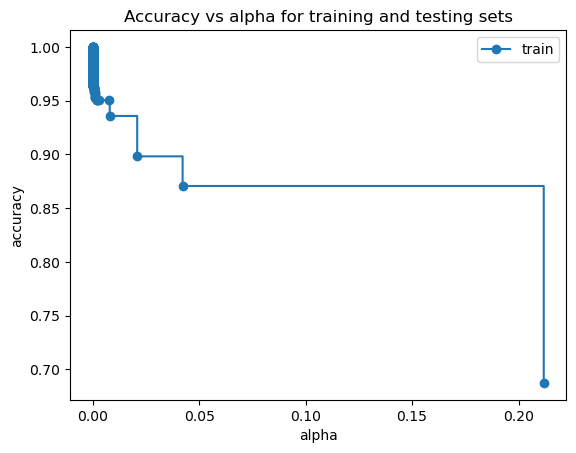

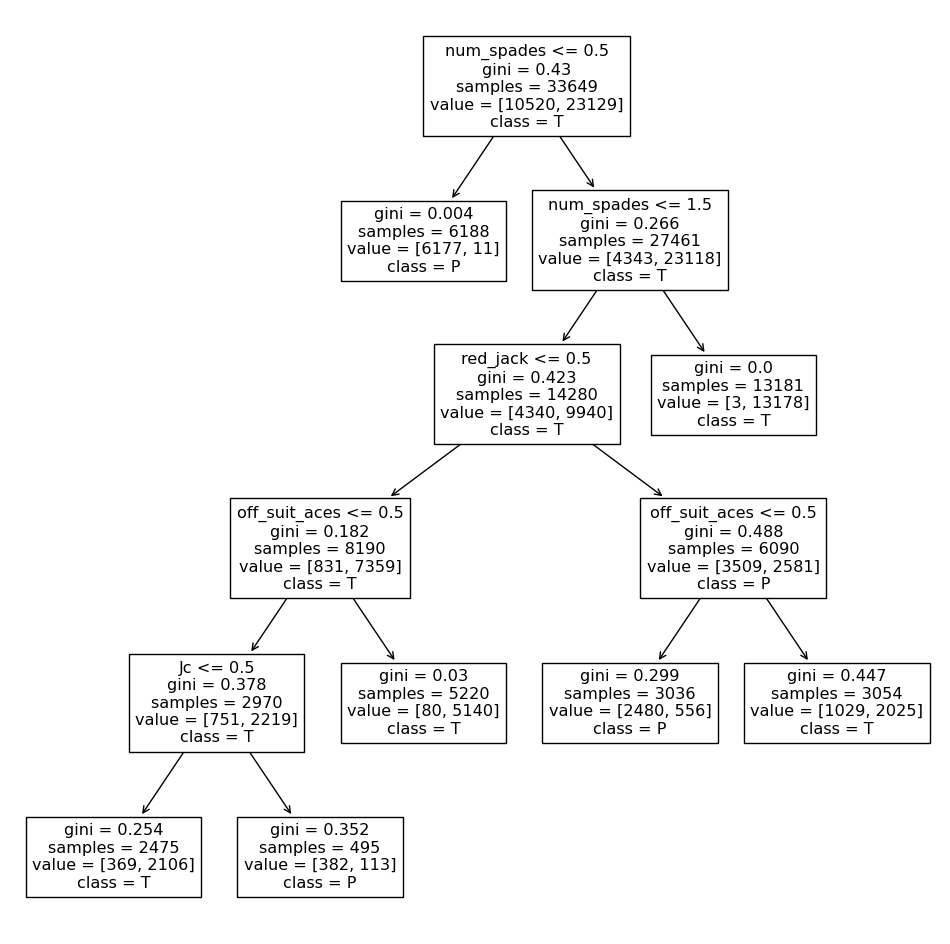

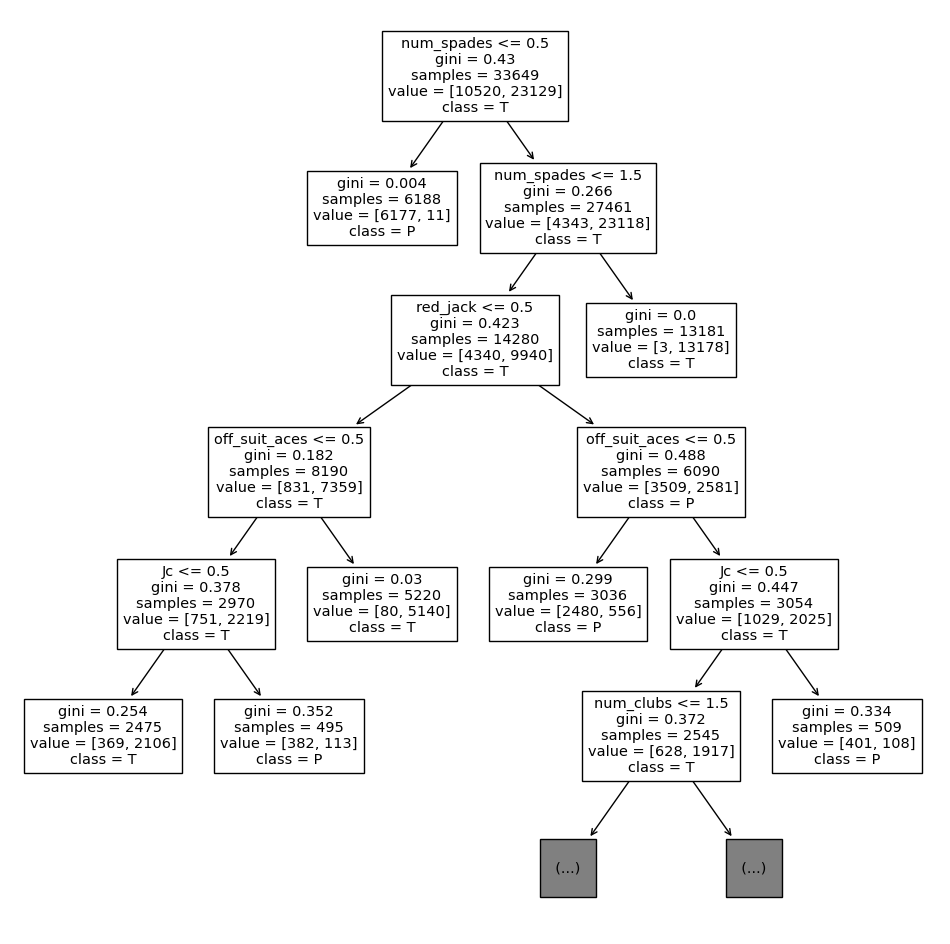

In [123]:
def create_decision_tree(data):
    df = pd.DataFrame.from_records(data)
    df = df[df.infostate.str.endswith("JsPPP")]
    # card_mask = df.hand.apply(lambda x: "Jc" in x)
    # df = df[card_mask]

    df["action"] = df.policy.apply(lambda x: max(x, key=x.get))

    for c in cards:
        df[c] = df.hand.apply(lambda x: c in x)

    df["num_spades"] = df.hand.apply(
        lambda x: len([c for c in x if c.endswith("s") or c == "Jc"])
    )
    df["num_clubs"] = df.hand.apply(
        lambda x: len([c for c in x if c.endswith("c") and c != "Jc"])
    )
    df["num_hearts"] = df.hand.apply(lambda x: len([c for c in x if c.endswith("h")]))
    df["num_diamons"] = df.hand.apply(lambda x: len([c for c in x if c.endswith("d")]))

    df["off_suit_aces"] = df.hand.apply(
        lambda x: len([c for c in x if c in ["Ac", "Ah", "Ad"]])
    )

    df["red_jack"] = df.hand.apply(lambda x: len([c for c in x if c in ["Jh", "Jd"]]))

    df["num_nines"] = df.hand.apply(lambda x: len([c for c in x if c.startswith("9")]))

    df = df.drop("infostate", axis=1)
    df = df.drop("policy", axis=1)
    df = df.drop("hand", axis=1)

    X_train = df.drop("action", axis=1)
    y_train = df.action
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    fig, ax = plt.subplots()
    ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
    ax.set_xlabel("effective alpha")
    ax.set_ylabel("total impurity of leaves")
    ax.set_title("Total Impurity vs effective alpha for training set")

    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)
    print(
        "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
            clfs[-1].tree_.node_count, ccp_alphas[-1]
        )
    )

    node_counts = [clf.tree_.node_count for clf in clfs]
    depth = [clf.tree_.max_depth for clf in clfs]
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
    ax[0].set_xlabel("alpha")
    ax[0].set_ylabel("number of nodes")
    ax[0].set_title("Number of nodes vs alpha")
    ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
    ax[1].set_xlabel("alpha")
    ax[1].set_ylabel("depth of tree")
    ax[1].set_title("Depth vs alpha")
    fig.tight_layout()

    train_scores = [clf.score(X_train, y_train) for clf in clfs]
    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
    ax.legend()
    plt.show()

    plt.figure(figsize=(12, 12))
    tree.plot_tree(
        clfs[-4],
        max_depth=5,
        feature_names=df.drop("action", axis=1).columns,
        class_names=["P", "T"],
    )

    plt.figure(figsize=(12, 12))
    tree.plot_tree(
        clfs[-5],
        max_depth=5,
        feature_names=df.drop("action", axis=1).columns,
        class_names=["P", "T"],
    )


create_decision_tree(raw_data)

## Example of outcomes for a given istate

 Why is `JcQcJhAh9d` a never take?

 Run 10k games resampled from istate:
 * How many make it to PPP?
 * Of that if we pass what happens? If we take what happens?

Do the columns as how trump was called and what was called (rows)
And then the columsn as the score

**Breakdown of games by points and dealer action**
|Points           |Pass       |Pickup     |
|---------------|-----------|-----------|
|-2 (Euchred, or other team takes tricks)            |0          |TBD   |
|-1 (lose, other team call) |   |   |
|1 (win, called)            |   |   |
|2 (Euchre other team, or take all tricks)  |TBD        |0     |
|**Average score**  |       |       |
